In [1]:
from __future__ import print_function #在python2的环境下，超前使用python3的print函数

# 其作用就是在你调用plot()进行画图或者直接输入Figure的实例对象的时候，会自动的显示并把figure嵌入到console中。
# 如果不加上%maplotlib inline 的话，每次figure的显示都需要plt.show();

#%matplotlib inline


import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 为了可重复性设置随机种子
manualSeed = 999
# manualSeed = random.randint(1, 10000) # 如果你想有一个不同的结果使用这行代码
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# 变量

In [7]:
# 数据集根目录
dataroot = "./celeba/"

# 数据加载器能够使用的进程数量
workers = 2

# 训练时的批大小
batch_size = 128

# 训练图片的大小，所有的图片给都将改变到该大小
# 转换器使用的大小.
image_size = 64

# 训练图片的通道数，彩色图片是3
nc = 3

# 本征向量z的大小(生成器的输入大小)
nz = 100

# 生成器中特征图大小
ngf = 64

# 判别器中特征图大小
ndf = 64

# 训练次数
num_epochs = 5

# 优化器学习率
lr = 0.0002

# Adam优化器的Beta1超参
beta1 = 0.5

# 可利用的GPU数量，使用0将运行在CPU模式。
ngpu = 1

# 数据

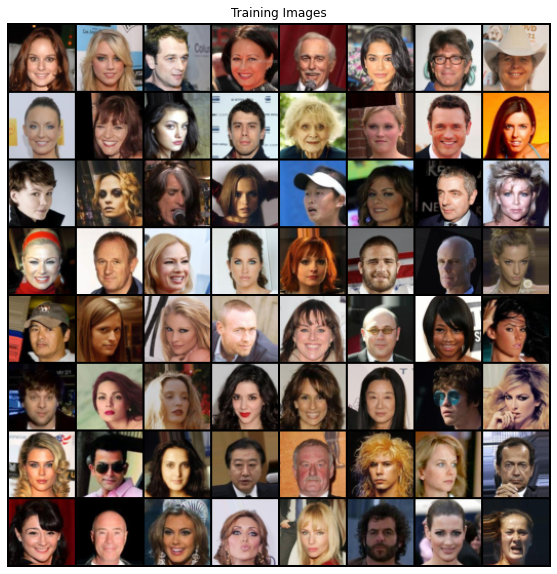

In [3]:
# 我们能够使用我们创建的数据集图片文件夹了
# 创建数据集
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# 创建数据加载器
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# 决定我们在哪个设备上运行
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 展示一些训练图片
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
# 制作图像网格
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# 权重初始化

In [4]:
# 在netG和netD上调用的自定义权重初始化函数
# 均值mean0，方差stdev0.02的正态分布随机初始化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 生成器

In [5]:
# 生成器代码

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 输入特征图大小. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 输入特征图大小. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 输入特征图大小. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 输入特征图大小. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输入特征图大小. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# 创建生成器
netG = Generator(ngpu).to(device)

# 如果期望使用多个GPU，设置一下。
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 使用权重初始化函数 weights_init 去随机初始化所有权重
#  mean=0, stdev=0.2.
netG.apply(weights_init)

# 输出该模型
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# 判别器